## Anomaly Detection

## Anomaly Detection

Find items that do not follow the distribution of the majority of data
![](images/fishes.png)


## Use cases - timeseries
- Predictive maintenance
- Fraud detection
- Intrusion detection


<img src="images/timeseries.png" alt="drawing" width="500"/>




## Use cases - images/video
- Medical imaging
- Defect detection in manufacturing
- CCTV
- Anti-counterfeit
<img src="images/image.png" alt="drawing" width="500"/>






### Types of models
- Semi-supervised
- Unsupervised
- Hybrid
- One-Class Neural Networks

## Autoencoder


![](images/autoencoder.png)

### How an autoencoder learns MNIST

![](images/out.gif)

### Autoencoder cannot reconstruct what it has not seen during training
![](images/example.png)

### Autoencoder cannot reconstruct what it has not seen during training
![](images/example2.png)

### Applications

Time Series Anomaly Detection

![](images/time_series.png)

### Applications

Feature Extraction / Data Compression

![](images/feature.png)

### Applications

Image Denoising

![](images/denoising.png)

### Types
- Vanilla autoencoder
- Deep autoencoder
- Convolutional autoencoder
- Spatio-temporal autoencoder

### Vanilla Autoencoder


In [1]:
from mxnet import gluon

class Autoencoder(gluon.Block):
    
    def __init__(self):
        
        super(Autoencoder, self).__init__()
        
        with self.name_scope():
            
            # Encoder
            self.encoder = gluon.nn.Dense(128, activation='relu')
            
            # Decoder
            self.decoder = gluon.nn.Dense(28 * 28, activation='tanh')

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

### Deep Autoencoder


In [2]:
class DeepAutoencoder(gluon.Block):
    
    def __init__(self):
    
        super(DeepAutoencoder, self).__init__()
        
        with self.name_scope():
        
            # Encoder
            self.encoder = gluon.nn.Sequential()
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Dense(128, activation='relu'))
                self.encoder.add(gluon.nn.Dense(64, activation='relu'))
                self.encoder.add(gluon.nn.Dense(12, activation='relu'))
                
                #Bottleneck
                self.encoder.add(gluon.nn.Dense(3))

            # Decoder
            self.decoder = gluon.nn.Sequential()
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(12, activation='relu'))
                self.decoder.add(gluon.nn.Dense(64, activation='relu'))
                self.decoder.add(gluon.nn.Dense(128, activation='relu'))
                self.decoder.add(gluon.nn.Dense(28 * 28, activation='tanh'))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

##  Convolutional Autoenocoder


In [3]:
class ConvolutionalAutoencoder(gluon.nn.HybridBlock):
    
    def __init__(self):
        
        super(ConvolutionalAutoencoder, self).__init__()
        
        with self.name_scope():
            
            # Encoder
            self.encoder = gluon.nn.HybridSequential(prefix="")
            with self.encoder.name_scope():
                self.encoder.add(gluon.nn.Conv2D(32, 5, padding=0, activation='relu'))
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.Conv2D(32, 5, padding=0, activation='relu'))
                self.encoder.add(gluon.nn.MaxPool2D(2))
                self.encoder.add(gluon.nn.Dense(100))
            self.decoder = gluon.nn.HybridSequential(prefix="")
            
            # Decoder
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(32*22*22, activation='relu'))
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.Conv2DTranspose(32, 5, activation='relu'))
                self.decoder.add(gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')))
                self.decoder.add(gluon.nn.Conv2DTranspose(1, kernel_size=5, activation='sigmoid'))


    def hybrid_forward(self, F, x):
        
        x = self.encoder(x)
        x = self.decoder[0](x)
        
        # need to reshape ouput feature vector from Dense(32*22*22), before it is upsampled
        x = x.reshape((-1,32,22,22))
        x = self.decoder[1:](x)

        return x

### Loss function - Mean Squared Error (L2):
- assumes pixel-wise indenpendence

<img src="images/l2loss.png" alt="drawing" width="1500"/>

### Loss function - Structural Similarity Index:
- structure
- contrast
- luminance

<img src="images/ssim.png" alt="drawing" width="1500"/>

### Customize Loss 

In [4]:
class SSIM(gluon.loss.Loss):
    def __init__(self, size = 11, weight=None, batch_axis=0, **kwargs):
        super(SSIM, self).__init__(weight, batch_axis, **kwargs)
        self.size = size
        self.channel = 3
        self.window = create_window(size, self.channel)
        
    def hybrid_forward(self, F, img1, img2):
        
        # Gaussian Filter
        self.window = self.window.as_in_context(img1.context)
        
        # mean
        mu1 = F.Convolution(data=img1, weight=self.window, kernel=(self.size,self.size), no_bias=True, pad=(self.size//2,self.size//2), num_filter=self.channel, num_group = self.channel)
        mu2 = F.Convolution(data=img2, weight=self.window, kernel=(self.size,self.size), no_bias=True, pad=(self.size//2,self.size//2), num_filter=self.channel, num_group = self.channel)
        
        # standard deviation
        mu1_sq = F.power(mu1,2)
        mu2_sq = F.power(mu2,2)
        
        mu1_mu2 = mu1*mu2
        
        sigma1_sq = F.Convolution(img1*img1, weight=self.window, kernel=(self.size,self.size), no_bias=True, pad=(self.size//2,self.size//2), num_filter=self.channel, num_group = self.channel) - mu1_sq
        sigma2_sq = F.Convolution(img2*img2, weight=self.window, kernel=(self.size,self.size), no_bias=True, pad=(self.size//2,self.size//2), num_filter=self.channel, num_group = self.channel) - mu2_sq
        sigma12 = F.Convolution(img1*img2, weight=self.window, kernel=(self.size,self.size), no_bias=True, pad=(self.size//2,self.size//2), num_filter=self.channel, num_group = self.channel) - mu1_mu2
       
        # luminance + contrast + structure
        ssim_map = ((2*mu1_mu2 + 0.0001)*(2*sigma12 + 2.7e-08))/((mu1_sq + mu2_sq + 0.0001)*(sigma1_sq + sigma2_sq + 2.7e-08))

        return ssim_map.mean()

### Image Anomaly Detection with Convolutional Autoencoders

UCSD dataset:
![](images/ucsd.png)

### Inference

<img src="images/autoencoder_dense.gif" alt="drawing" width="1500"/>

### Inference
Without bottleneck layer, the model can not learn meaningful features:

<img src="images/autoencoder_nodense.gif" alt="drawing" width="1500"/>

### Takeaways

No size fits all:

- how much variation in the training set
- size of anomalies
- type of data (image, audio, etc)

## Anomaly Detection in Videos

### Problem of the previous model:
- we do not assume any dependency/order between images
- need to train model on sequence of images
- need to use LSTM cells to learn sequence

![](images/Picture9.png)

### Spatio-temporal Autoencoder


In [5]:
class ConvLSTMAE(gluon.nn.HybridBlock):
    def __init__(self, **kwargs):
        super(ConvLSTMAE, self).__init__(**kwargs)
        with self.name_scope():

          # Encoder
          self.encoder = gluon.nn.HybridSequential()
          self.encoder.add(gluon.nn.Conv2D(128, kernel_size=11, strides=4, activation='relu'))
          self.encoder.add(gluon.nn.Conv2D(64, kernel_size=5, strides=2, activation='relu'))

          # Temporal Encoder
          self.temporal_encoder = gluon.rnn.HybridSequentialRNNCell()
          self.temporal_encoder.add(gluon.contrib.rnn.Conv2DLSTMCell((64,26,26), 64, 3, 3, i2h_pad=1))
          self.temporal_encoder.add(gluon.contrib.rnn.Conv2DLSTMCell((64,26,26), 32, 3, 3, i2h_pad=1))
          self.temporal_encoder.add(gluon.contrib.rnn.Conv2DLSTMCell((32,26,26), 64, 3, 3, i2h_pad=1))

          # Decoder
          self.decoder =  gluon.nn.HybridSequential()
          self.decoder.add(gluon.nn.Conv2DTranspose(channels=128, kernel_size=5, strides=2, activation='relu'))
          self.decoder.add(gluon.nn.Conv2DTranspose(channels=10, kernel_size=11, strides=4, activation='sigmoid'))

    def hybrid_forward(self, F, x, states=None, **kwargs):
        x = self.encoder(x)
        x, states = self.temporal_encoder(x, states)
        x = self.decoder(x)
        
        return x, states

### Convolutional LSTM
*Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting* (NIPS 2015)

#### Fully Connected LSTM:
- powerful for handling temporal data
- too much redundancy for spatial data
- input-to-state and state-to-state transitions do not encode spatial information

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" alt="drawing" width="1000"/>

*Taken from https://colah.github.io/posts/2015-08-Understanding-LSTMs/* 


#### Convolutional LSTM:
- determines future state of a cell based on inputs and past states of its neighbors
![](https://cdn-images-1.medium.com/max/640/1*u8neecA4w6b_F1NgnyPP0Q.png)
*Taken from https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7*

### Lab: find anamlous movements and objects in UCSD dataset


### Import modules and define hyperparameters

In [12]:
import glob
import numpy as np
from urllib import request
import tarfile
import os
import mxnet as mx
from mxnet import gluon
from PIL import Image
from scipy import signal
from matplotlib import pyplot as plt

ctx = mx.cpu()
num_epochs = 0
batch_size = 16



### Define Dataloader


In [13]:
#Download dataset 
if not os.path.isfile("UCSD_Anomaly_Dataset.tar.gz"):
  response = request.urlretrieve("http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz", "UCSD_Anomaly_Dataset.tar.gz")
  tar = tarfile.open("UCSD_Anomaly_Dataset.tar.gz")
  tar.extractall()
  tar.close()

### Create the model

In [14]:
# Get model
model = ConvolutionalAutoencoder()
model.hybridize()
#model.collect_params().initialize(mx.init.Xavier(), ctx=mx.gpu())
model.load_parameters("autoencoder_ucsd.params", ctx=ctx)

# Loss
l2loss = gluon.loss.L2Loss()

# Trainer
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 1e-4, 'wd': 1e-5, 'epsilon':1e-6})

#### Train the model

In [15]:
# Start the training loop
for epoch in range(num_epochs):
    
    # iterate over bacthes of training images
    for image in dataloader:
        
        # load image on the right context
        image  = image.as_in_context(ctx)

        with mx.autograd.record():
            
            # forward pass
            reconstructed = model(image)
            
            # compute loss
            loss = l2loss(reconstructed, image)

        # backpropagation    
        loss.backward()
        optimizer.step(batch_size)

    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, mx.nd.mean(loss).asscalar()))

# save model parameters
model.save_parameters("mymodel.params")

#### Inference
![](images/lstmae.gif)

### Test

In [18]:
# Path to test images
files = sorted(glob.glob('UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/*'))

a = np.zeros((len(files),1,100,100))

# load and resize images
for idx,filename in enumerate(files):
    im = Image.open(filename)
    im = im.resize((100,100))
    a[idx,0,:,:] = np.array(im, dtype=np.float32)/255.0

# define dataloader
dataset = gluon.data.ArrayDataset(mx.nd.array(a, dtype=np.float32))
dataloader = gluon.data.DataLoader(dataset, batch_size=1)

### Helper function for plotting

In [19]:
def plot(img, output, diff, H, threshold):
    
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    # find pixel values with high reconstruction error and mark them
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.8) 
    plt.show()

In [22]:
# iterate over test images
for image in dataloader:

    # load image on the right context
    img = image.as_in_context(mx.cpu())

    # inference
    output = model(img)

    # convert from MXNet NDarray to Numpy array
    output = output.asnumpy()
    img = image.asnumpy()
    
    # compute residual map
    diff = np.abs(output-img)
    
    # perform 2d convolution on residual map
    tmp = diff[0,0,:,:]
    H = signal.convolve2d(tmp, np.ones((8,8)), mode='same')
 
    break

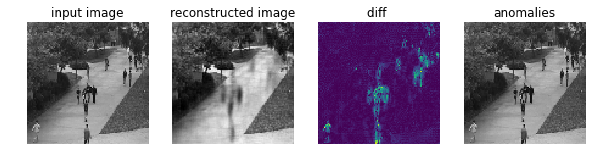

In [23]:
# plot images
plot(img[0,0,:,:], output[0,0,:,:], diff[0,0,:,:], H, 15)